# Time Series EDA

- Time Series Train-Test Split
    1. Human-based
    1. Percentage Based
    1. Cross Validate Splits
- 10 Weird Time Series Visualizations to Impress Your Friends and Family (Doctors Hate Her)
    1. Blow off the time series
    1. y over time
    1. y averaged over various periods over time
    1. change in y over time
    1. Seasonal Plot
    1. Seasonal Subseries Plot
    1. Lag Plot
    1. Autocorrelation Plot
    1. Seasonal Decomposition
    1. Area Plots
- Aside: working with dates in matplotlib
- Aside: `strftime`

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from env import user, password, host
import os

# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

url = 'https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv'
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
# converting the units of the data we are ingesting
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
df.head()

df.shape[0]

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00


45252

In [2]:
df.head()

,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747


In [3]:
df.size, df.shape

(45252, (45252, 1))

In [4]:
df.tail(2)

,temp
datetime,
2017-11-29 23:00:00,71.834
2017-11-30 00:00:00,65.966


In [5]:
df.temp.describe()

count    45252.000000
mean        69.144163
std         14.946638
min         17.420000
25%         59.810000
50%         71.661650
75%         79.412000
max        104.918000
Name: temp, dtype: float64

- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Train-Test Split

- Ideally all splits contain a season
- Human-based: use the last year as test
- Percentage based: use the last 20% as test
- Cross Validate: break data up into slices and use successive slices as train and test repeatedly (`sklearn.model_selection.TimeSeriesSplit`)
    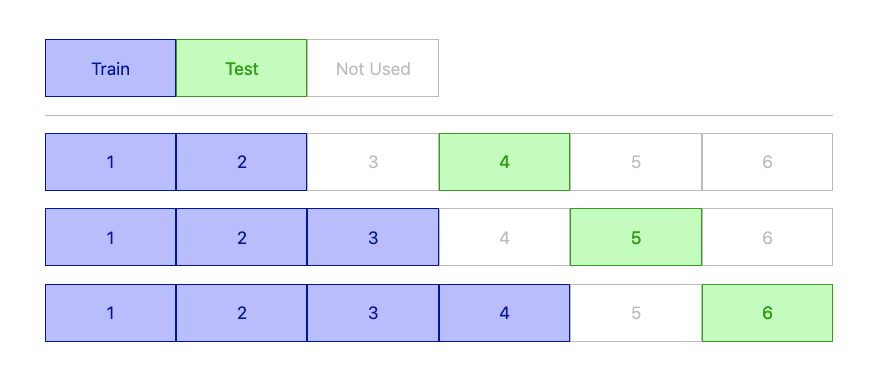

In [8]:
def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    query = '''
    SELECT *
    FROM items
    JOIN sales USING(item_id)
    JOIN stores USING(store_id) 
    '''
    
    df = pd.read_sql(query, get_db_url('tsa_item_demand'))
    
    df.to_csv('tsa_item_demand.csv', index=False)
    
    return df

def wrangle_store_data():
    filename = 'tsa_store_data.csv'
    
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
        
    return df

In [9]:
df = wrangle_store_data()

In [11]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,2013-01-04,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,2013-01-05,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


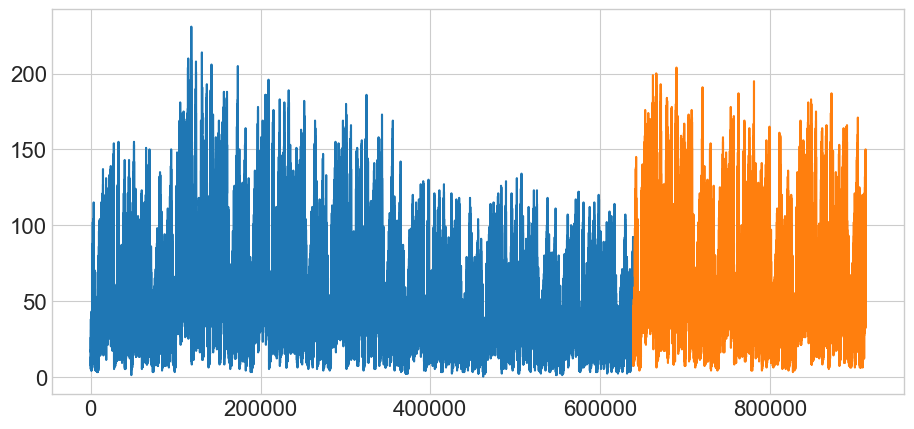

In [12]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index]
test = df[test_start_index:] 

plt.plot(train.index, train.sale_amount)
plt.plot(test.index, test.sale_amount)

In [18]:
y = train.sale_amount
y.head()

0    13
1    11
2    14
3    13
4    10
Name: sale_amount, dtype: int64

<AxesSubplot:ylabel='Frequency'>

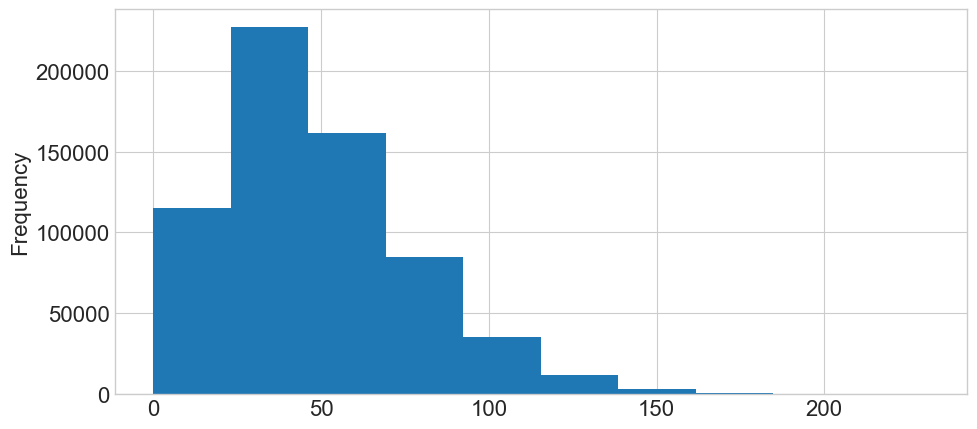

In [19]:
y.plot.hist()

Text(0.5, 1.0, 'Lag plot with lag=1')

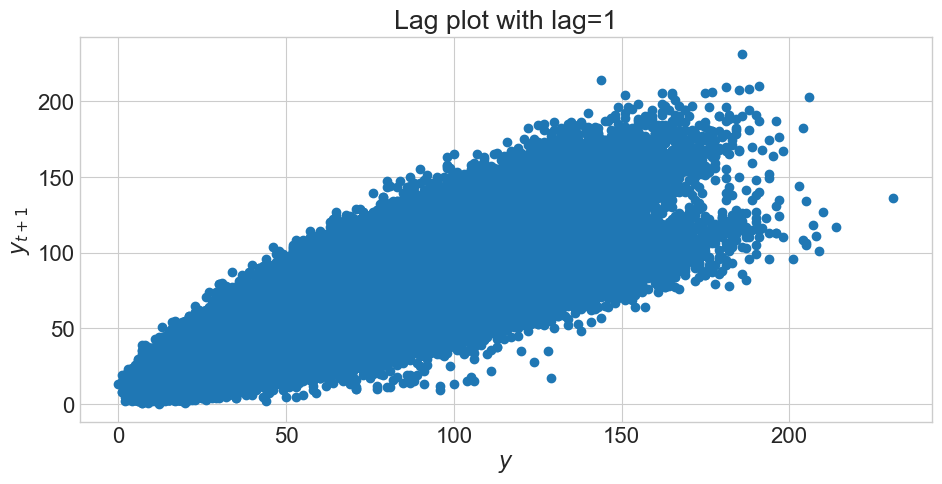

In [23]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

In [28]:
germany = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')
germany.to_csv('germany.csv')
germany

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [40]:
traing = germany[:test_start_index]
testg = germany[test_start_index:] 

In [39]:
g = traing.Consumption
g.head()

0    1069.184
1    1380.521
2    1442.533
3    1457.217
4    1477.131
Name: Consumption, dtype: float64

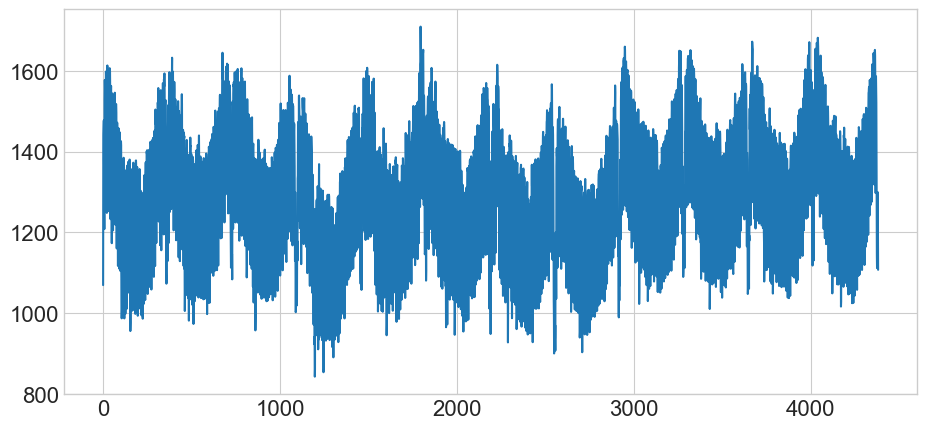

In [41]:
plt.plot(traing.index, traing.Consumption)
plt.plot(testg.index, testg.Consumption)

<AxesSubplot:ylabel='Frequency'>

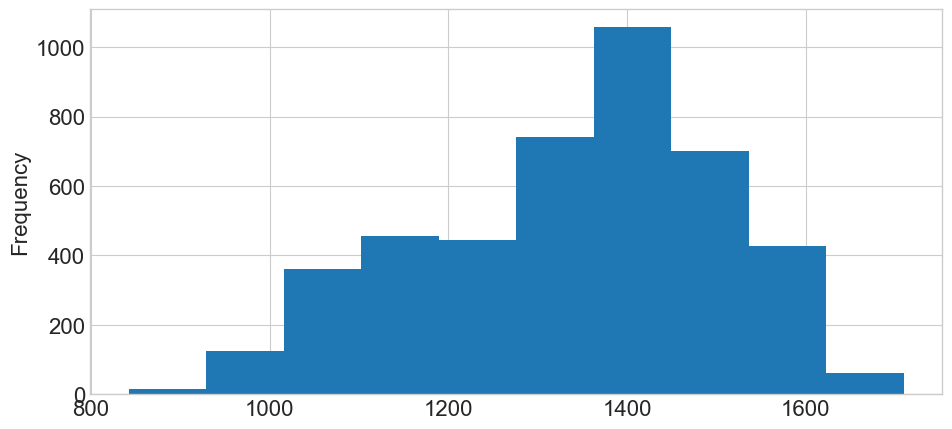

In [42]:
g.plot.hist()

Text(0.5, 1.0, 'Lag plot with lag=1')

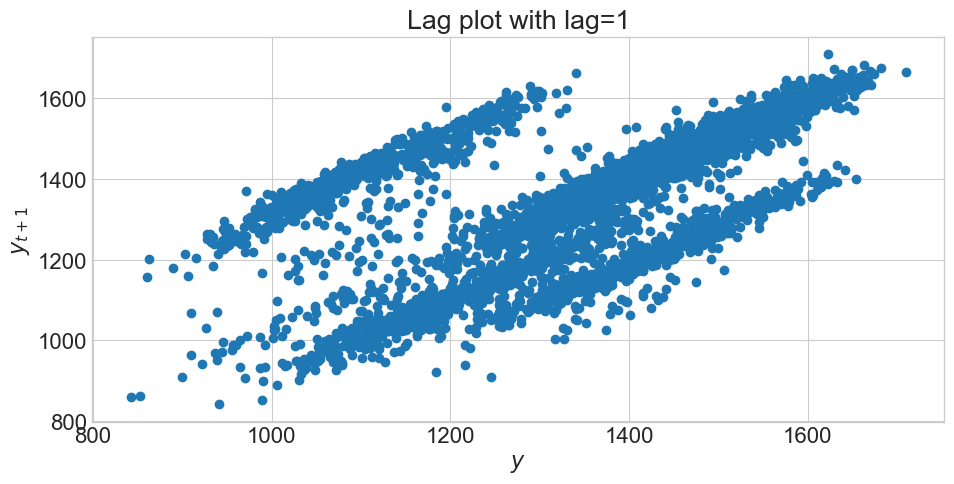

In [43]:
plt.scatter(g, g.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')